In [1]:
import torch
import numpy as np
from torchtext.legacy import data
from torchtext.legacy import datasets

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [2]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [3]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [4]:
TEXT = data.Field(batch_first = True, use_vocab = False, tokenize = tokenize_and_cut, 
                  preprocessing = tokenizer.convert_tokens_to_ids, init_token = init_token_idx,
                  eos_token = eos_token_idx, pad_token = pad_token_idx, unk_token = unk_token_idx)
LABEL = data.LabelField(dtype = torch.float)

fields = [('text', TEXT), ('label', LABEL)]
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'dataset_2class',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
)


In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4549
Number of validation examples: 800
Number of testing examples: 800


In [6]:
LABEL.build_vocab(train_data)

In [7]:
print(LABEL.vocab.stoi)

defaultdict(None, {'0': 0, '1': 1})


In [8]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort = False,
    device = device)

In [9]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [11]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [12]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [13]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [15]:
def compute_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [16]:
from torchmetrics.functional import accuracy, precision, recall, f1

def compute_metrics(preds, y):
    """
    Returns precision, recall, F1-score of per batch
    """
    class_preds = torch.round(torch.sigmoid(preds))
    return (accuracy(class_preds, y.int()), 
            precision(class_preds, y.int()), 
            recall(class_preds, y.int()), 
            f1(class_preds, y.int()))

In [17]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, prec, recall, f1 = compute_metrics(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [18]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc, prec, recall, f1 = compute_metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 15

best_valid_loss = float('inf')
train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)
valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)


for i in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model, train_iterator, optimizer, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model, valid_iterator, criterion)
    
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'tut8-model-2class.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}% | Train Prec: {train_prec[i]*100:.2f}% | Train Recall: {train_recall[i]*100:.2f}% | Train F1: {train_f1[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}% |  Val. Prec: {valid_prec[i]*100:.2f}% |  Val. Recall: {valid_recall[i]*100:.2f}% | Val.  F1: {valid_f1[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 0.637 | Train Acc: 64.64% | Train Prec: 63.44% | Train Recall: 34.36% | Train F1: 42.89%
	 Val. Loss: 0.584 |  Val. Acc: 70.87% |  Val. Prec: 64.56% |  Val. Recall: 68.07% | Val.  F1: 65.94%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 0.534 | Train Acc: 74.47% | Train Prec: 75.28% | Train Recall: 63.35% | Train F1: 67.99%
	 Val. Loss: 0.471 |  Val. Acc: 78.24% |  Val. Prec: 73.90% |  Val. Recall: 74.71% | Val.  F1: 74.03%
Epoch: 03 | Epoch Time: 0m 47s
	Train Loss: 0.437 | Train Acc: 80.21% | Train Prec: 79.56% | Train Recall: 74.14% | Train F1: 76.40%
	 Val. Loss: 0.461 |  Val. Acc: 80.02% |  Val. Prec: 73.06% |  Val. Recall: 83.57% | Val.  F1: 77.69%
Epoch: 04 | Epoch Time: 0m 46s
	Train Loss: 0.398 | Train Acc: 82.63% | Train Prec: 81.27% | Train Recall: 78.19% | Train F1: 79.41%
	 Val. Loss: 0.431 |  Val. Acc: 81.58% |  Val. Prec: 78.46% |  Val. Recall: 77.95% | Val.  F1: 77.94%
Epoch: 05 | Epoch Time: 0m 47s
	Train Loss: 0.387 | Train Ac

In [21]:
model.load_state_dict(torch.load('tut8-model-2class.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test prec: {test_prec*100:.2f}% |Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.354 | Test Acc: 85.83% | Test prec: 88.76% |Test Recall: 78.80% | Test F1: 83.22%


### ROC

In [22]:
import spacy
import numpy as np
nlp = spacy.load('en_core_web_sm')

def predict_singleSentence(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = int(round(torch.sigmoid(model(tensor)).item()))
    return prediction

def predict_sentiment(model, sentences):
    pred_res = []
    for i, sentence in sentences.items():
        pred_res.append(predict_singleSentence(model, tokenizer, sentence))
    return pred_res

In [23]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def prec_rec_curve(model, X, Y_true, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test = Y_true
    predict_res = predict_sentiment(model, X)
    y_score = predict_res
    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    plt.plot(fpr[0], tpr[0], color="cornflowerblue", lw=2,
                 label='ROC curve (area = {1:0.2f})'.format(0, roc_auc[0]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

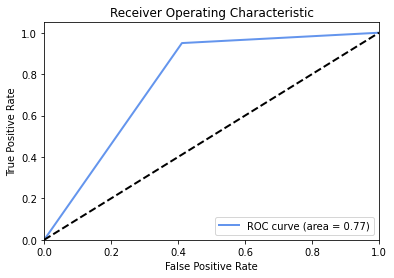

In [24]:
import pandas as pd
test_df = pd.read_csv("dataset_2class/test.csv", header=None)

prec_rec_curve(model, test_df[0], test_df[1])

### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix

y_test_pred = predict_sentiment(model,  test_df[0])
y_test_true = test_df[1]
cm = confusion_matrix(y_test_pred, y_test_true, normalize='true')
cm

array([[0.93501805, 0.06498195],
       [0.34608031, 0.65391969]])

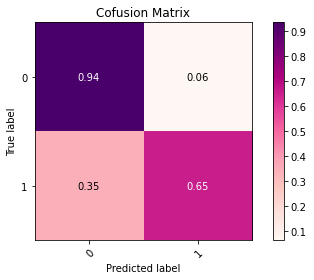

In [26]:
normalize = True
cmap = 'RdPu'
classes = ['0', '1']
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()

### Metric Curve

Text(0, 0.5, 'Loss')

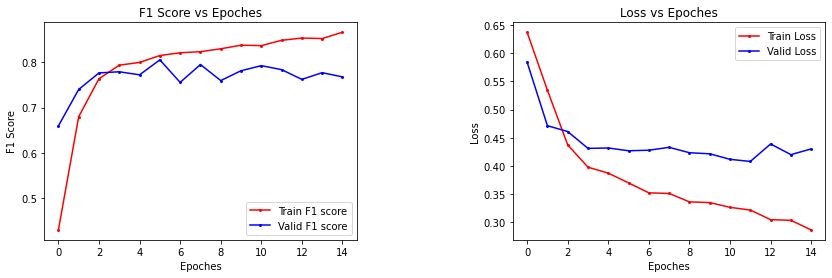

In [27]:
totEpoch = N_EPOCHS
x = range(0, totEpoch)
plt.figure(figsize=(14,4))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
# plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
plt.legend()
plt.title('F1 Score vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('F1 Score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
plt.legend()
plt.title('Loss vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')

In [28]:
df = pd.read_csv("covidvaccine_tweet_sentiment.csv", header=0)
y_pred = predict_sentiment(model,  df.loc[:, "text"].apply(str))
df['veracity'] = y_pred
df.to_csv("covidvaccine_tweet_sentiment_veracity_BERT.csv", index=False)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
